# TP 7 : Random Forest

# <div class="alert alert-block alert-success">
<b>Informations générales </b>
</div>

**Professeur**: Stephan Robert

**Assistant(s)**: Félicien Hêche

**Contact**: stephan.o.robert@gmail.com, felicien.heche@gmail.com ou via Teams

**Rendu**:

- Date: 9 Janvier 2024
- Modalité: Travail individuel. Une fois complétées, copiez les réponses dans le ficher "**TP7_APV_S1-2023_Nom_Prenom.*****" (*** = ce que vous voulez qui soit lisible pour nous: .pdf, .html, ...) en remplaçant Nom et Prenom par les votres puis uploader votre fichier sur Cyberlearn.
- Note: Ce TP est noté sur 6, pour un poids de x%

**Étudiant**:

- Hugo Huart

<div class="alert alert-block alert-success">

<b>But du TP </b>
</div>

Le but de ce travail pratique est d'implémenter un algorithme appelé Random Forest! Dans ce travail pratique, nous allons travailler avec un dataset trouvé sur kaggle. Ce dataset est assez brute et par conséquent, il faudra faire un peu de préprocessing avant de pouvoir l'utiliser.


<!---
<div class="alert alert-block alert-info">
<b>Rappel </b>
</div>
-->

<div class="alert alert-block alert-success">
<b>Table des matières </b>
</div>

1. Data préparation
2. Random Forest
3. Test

Commencons par importer quelques packages.

In [97]:
import itertools
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from statistics import mode
from sklearn.tree import DecisionTreeRegressor
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder
from scipy import stats
import pandas as pd
import re

## 1. Data préparation

Pour ce TP, nous allons travailler avec un dataset qui se nomme 'Australian Housing Prices'. Ce dataset vient de kaggle (plus d'information [ici](https://www.kaggle.com/datasets/thedevastator/australian-housing-data-1000-properties-sampled)). Ce fichier contient 27 features concernant $1000$ maisons/appartements australiens ainsi que le prix de vente de la maison/appartement en question. Dans ce travail pratique, nous allons utiliser l'algorithme de random forest afin d'estimer le prix d'une maison/appartement.

Commençons par essayer de comprendre un peu mieux le dataset.

In [43]:
df = pd.read_csv('train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Comme vous pouvez le voir, notre dataset n'est pas utilisable comme tel, car il a des données manquantes et des features de type string. Nous allons donc commencer par préparer notre dataset.

### 1.1 Gestion des données manquantes

Pour commencer nous allons gérer nos données manquantes. En effet, comme nous pouvons le constater, il y a actuellememt un grand nombre de données manquantes dans notre jeux de données.


In [44]:
print("Il y a %d observations avec des données manquantes" % df.isna().any(axis=1).sum())

Il y a 1460 observations avec des données manquantes


En première approche, nous allons donc déterminer et supprimer les features de notre dataset qui ont un nombre de valeurs manquantes trop élevées.

In [45]:
missing_features = df.columns[df.isna().sum() > 200].to_list()
print(missing_features)

df = df.drop(missing_features, axis=1)

['LotFrontage', 'Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']


Ensuite, il est également, préférable de supprimer la colonne 'Id'.

In [46]:
df = df.drop("Id", axis=1)

In [47]:
print("Il y a %d observations avec des données manquantes" % df.isna().any(axis=1).sum())

Il y a 122 observations avec des données manquantes


Bien que le nombre de données manquantes ait significativement diminué, il reste encore quelques données manquantes. Pour finir, nous allons donc supprimer les lignes dans lesquelles il y a encore des données manquantes.

In [48]:
missing_observations = df.isna().any(axis=1)
df = df.drop(df[missing_observations].index)

In [49]:
print("Il y a %d observations avec des données manquantes" % df.isna().any(axis=1).sum())

Il y a 0 observations avec des données manquantes


## 1.3 Numérisation

Maintenant que nous avons géré le problème des données manquantes, passons au problème suivant. Comme vous avez pu le constater toutes les valeurs présentes dans notre dataset ne sont pas de type numérique. Cela est évidemment problématique, car nous devons nourrir notre modèle avec des données de ce type.

Nous allons donc gérer ce problème ici.

In [50]:
df.head()

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,...,0,0,0,0,0,12,2008,WD,Normal,250000


In [51]:
def numerise_data(df: pd.DataFrame):
    cols = df.columns
    ret = pd.DataFrame(OrdinalEncoder(dtype=np.int64).fit_transform(df), columns=cols)

    return ret

Maintenant, nous pouvons convertir nos données string en données numéric.

In [52]:
df = numerise_data(df)

Evidemment, nous pouvons vérifier que tout a bien fonctionné.

In [53]:
df.head()

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,5,3,287,1,3,3,0,4,0,5,...,0,0,0,0,0,1,2,8,4,371
1,0,3,448,1,3,3,0,2,0,24,...,0,0,0,0,0,4,1,8,4,303
2,5,3,641,1,0,3,0,4,0,5,...,0,0,0,0,0,8,2,8,4,400
3,6,3,439,1,0,3,0,0,0,6,...,98,0,0,0,0,1,0,8,0,160
4,5,3,857,1,0,3,0,2,0,15,...,0,0,0,0,0,11,2,8,4,452


Evidemment, la manière dont nous avons préparé le dataset est très simpliste. Si nous étions intéressé à construire un modèle performant, il aurait pu être pertinent d'approfondir cette étape (détection de potentiel valeurs aberrantes, gestion de ces derniers, feature sélecion, ...).

### 1.4 Data splitting

Maintenant que notre dataset est prêt, nous pouvons construire notre training et test dataset.

In [54]:
X = df.drop("SalePrice", axis=1)
Y = df["SalePrice"]

X_train, X_valtest, Y_train, Y_valtest = train_test_split(X, Y, test_size=0.3)
X_val, X_test, Y_val, Y_test = train_test_split(X_valtest, Y_valtest, test_size=0.5)

## 2. Random Forest

Pour continuer, nous pouvons travailler sur l'implémentation de l'algorithme de Random Forest. L'idée de cet algorihme est très simple : construire un ensemble d'arbre de décision où chaque arbre sera entraînés sur dataset différents. Pour créer ces différents datasets, l'approche classique consiste à faire du bootstraping. 

De plus, la manière de construire ces arbres est un peu spécifique. En effet lors de la construction, pour choisir le prochain noeud, on va considérer le meilleur feature parmi un certain sous-ensemble aléatoirement choisi de features. Plus précisément s'il y a $n$ features possible, il est courant de choisir aléatoirerement $\sqrt n$ features et de choisir le meilleur parmi ces $\sqrt n$ features.

Finalement, une fois que notre Random Forest a été construit et que nous souhaitons faire une régression, il suffit de considérer la moyenne des différentes prédictions. Dans le cas d'une classification, il suffit de choisir la classe avec le plus de votes.

In [90]:
class RandomForest:
    """
    An implementation of Random Forest algorithm
    """

    def _boostrap_idx(self, n, size):
        return np.random.choice(np.arange(n), size) 
    
    def _grow_trees(self, X, Y, forest_size, bootstrap_factor):
        max_features = np.int64(np.round(np.sqrt(forest_size)))
        trees = list()

        for _ in range(forest_size):
            idx = self._boostrap_idx(len(X), round(len(X) * bootstrap_factor))
            x = X.iloc[idx]
            y = Y.iloc[idx]

            tree = DecisionTreeRegressor(max_features=max_features)
            tree.fit(x, y)
            trees.append(tree)

        return trees

    def fit(self, X, Y):
        self.trees = self._grow_trees(X, Y, self.forest_size, self.bootstrap_factor)
        return self

    def predict(self, X):
        if self.trees == None:
            print("The regressor is not fitted")
            return
        
        results = np.zeros(shape=(self.forest_size, len(X)))
        for i in range(self.forest_size):
            tree = self.trees[i]
            results[i] = tree.predict(X)
        
        return np.mean(results, axis=0)
    
    def __init__(self, forest_size=10, bootstrap_factor=1):
        self.forest_size = forest_size
        self.bootstrap_factor = bootstrap_factor
        self.trees = None

## 3. Test

Pour finir, nous allons construire et tester notre algorithme.

### 3.1 Hyperparameters tuning

En utilisant le training et le validation dataset précédemment, faites un peu d'hypermeter tuning. En particulier, tester quelques valeurs différentes pour le nombre d'arbre présents. Evaluer la performance de votre modèle en utilisant l'erreur absolue moyenne.

In [116]:
def plot_heatmap(x, y, z, xlab="", ylab="", title="", reversed=False, size=(13, 12)):
    fig = plt.figure(figsize=size)
    ax = fig.add_subplot()

    ax.set_xticks(np.arange(len(y)), labels=y)
    ax.set_yticks(np.arange(len(x)), labels=x)

    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(title)

    im = ax.imshow(z, origin="lower", cmap="cividis" if not reversed else "cividis_r")
    for i in np.arange(len(x)):
        for j in np.arange(len(y)):
            text = ax.text(j, i, "%.1f" % z[i, j], ha="center", va="center", color="w")

In [123]:
factors = np.arange(1, 5 + 1, 1)
sizes = np.arange(5, 30 + 1, 1)

n_factors = len(factors)
n_sizes = len(sizes)

errors = np.zeros(shape=(n_factors, n_sizes))

for (factors_idx, sizes_idx) in itertools.product(range(n_factors), range(n_sizes)):
    size = sizes[sizes_idx]
    bootstrap_factor = factors[factors_idx]

    pred = RandomForest(forest_size=size, bootstrap_factor=3).fit(X_train, Y_train).predict(X_val)
    errors[factors_idx, sizes_idx] = mean_absolute_error(Y_val, pred)

    print(f"Error({size}, {bootstrap_factor})= {errors[factors_idx, sizes_idx]}")

Error(5, 1)= 48.55223880597015
Error(6, 1)= 47.51658374792702
Error(7, 1)= 43.025586353944554
Error(8, 1)= 47.0136815920398
Error(9, 1)= 43.333333333333336
Error(10, 1)= 45.84477611940298
Error(11, 1)= 40.819990954319316
Error(12, 1)= 40.563847429519065
Error(13, 1)= 42.09337925755836
Error(14, 1)= 41.47121535181237
Error(15, 1)= 40.38474295190713
Error(16, 1)= 41.096703980099505
Error(17, 1)= 38.85133157740708
Error(18, 1)= 41.777224986180215
Error(19, 1)= 41.03796805446452
Error(20, 1)= 38.05124378109453
Error(21, 1)= 40.59132906894101
Error(22, 1)= 39.1831750339213
Error(23, 1)= 41.0209820462903
Error(24, 1)= 38.60530679933665
Error(25, 1)= 38.82228855721393
Error(26, 1)= 41.442594718714126
Error(27, 1)= 38.59941035562926
Error(28, 1)= 38.69776119402985
Error(29, 1)= 39.0349974266598
Error(30, 1)= 39.97296849087894
Error(5, 2)= 48.242786069651736
Error(6, 2)= 42.56799336650083
Error(7, 2)= 47.169154228855724
Error(8, 2)= 45.67786069651741
Error(9, 2)= 41.783858485351026
Error(10, 2)

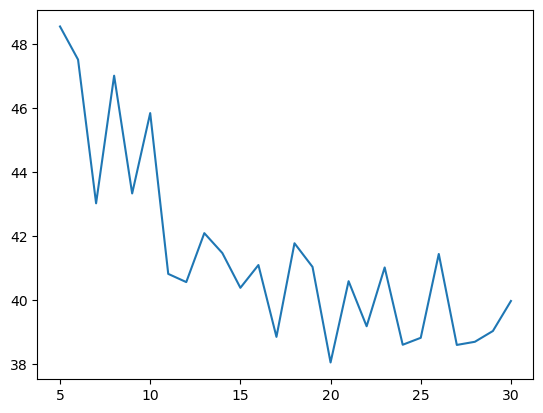

In [127]:
plt.plot(sizes, errors[0,:])

plt.show()

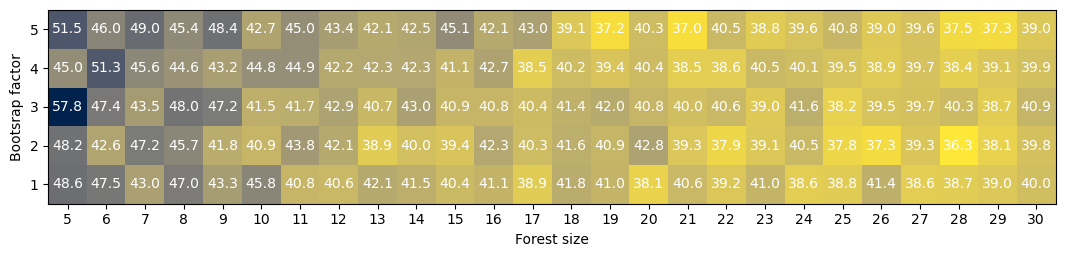

In [124]:
plot_heatmap(factors, sizes, errors, xlab="Forest size", ylab="Bootsrap factor", reversed=True)

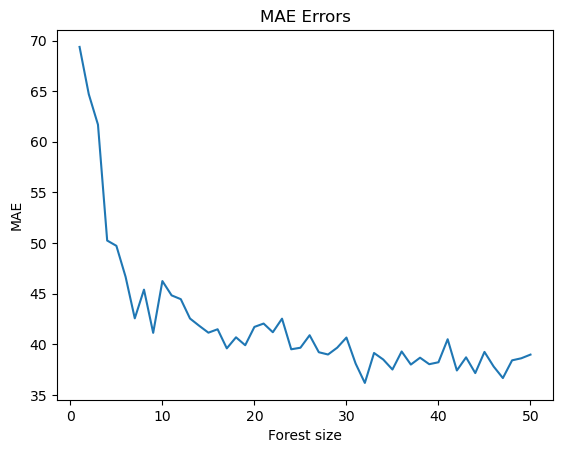

In [93]:
plt.plot(sizes, errors)

plt.xlabel("Forest size")
plt.ylabel("MAE")
plt.title("MAE Errors")
plt.show()

Une taille de forêt valant autour de 25~30 semble produire une erreur minimale

### 3.2 Evaluation du modèle et comparaisons

En utilisant les meilleurs paramètres trouvé au point précédent, construiser un modèle et évaluer son erreur absolue moyenne sur le test dataset.

In [59]:
# TODO : build and test the best model using parameters found above on the test dataset.

Ensuite, comparer votre modèle avec un arbre de décision.

In [60]:
# TODO : build and test a simple decision tree.

Pour finir, comparer la performance de votre modèle avec un RandomForestRegressor fourni par sklearn. Comme des processus aléatoires sont utilisés pour construire ces modèles, il est normal d'obtenir des résultats qui diffèrent un peu.

In [61]:
# Build and test a RandomForestRegressor model provided by sklearn